In [1]:
import sys
sys.path.append("/home/yanhu/data/PRINT/multiScaleFootprinting/code")
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
import scprinter as scp
import time
import pandas as pd
import numpy as np
import pybedtools
import matplotlib.pyplot as plt
import os
import re
import math
import copy
import pyBigWig
from tqdm import tqdm
from zipfile import ZipFile
import seaborn as sns
import scipy.stats as ss
wd = '/home/yanhu/data/PRINT/multiScaleFootprinting/data/degron/CTCF_ENCODE'

## Initialize scPrinter for footprinting

In [2]:
# Sample barcodes
barcodes = ['ENCFF712GEL_ENCFF858VWC_CTCF_Un_Rep1_S1',
 'ENCFF668ATD_ENCFF582TRW_CTCF_Treated_Rep1_S1',
 'ENCFF364WVP_ENCFF680DCL_CTCF_Un_Rep2_S1',
 'ENCFF308LPR_ENCFF584DFW_CTCF_Treated_Rep2_S1']

# Initialize scPrinter object
printer = scp.pp.import_fragments(
    pathToFrags=os.path.join(wd, 'all.frags.tsv.gz'),
    barcodes=barcodes,
    savename=os.path.join(wd, 'printer_data.h5ad'),
    genome=scp.genome.hg38,
    sorted_by_barcode=True)
printer.load_disp_model()

# Create barcode grouping
barcode_groups = pd.DataFrame([barcodes, np.arange(4)]).T
barcode_groups.columns = ['barcode','group']
grouping, unique_groups = scp.df2cell_grouping(printer, barcode_groups)
barcode_groups

You are now using the beta auto_detect_shift function, this overwrites the plus_shift and minus_shift you provided
If you believe the auto_detect_shift is wrong, please set auto_detect_shift=False
detected plus_shift and minus_shift are 4 -5
snapatac2 shift check True
Initializing GFF-db


,barcode,group
0,ENCFF712GEL_ENCFF858VWC_CTCF_Un_Rep1_S1,0
1,ENCFF668ATD_ENCFF582TRW_CTCF_Treated_Rep1_S1,1
2,ENCFF364WVP_ENCFF680DCL_CTCF_Un_Rep2_S1,2
3,ENCFF308LPR_ENCFF584DFW_CTCF_Treated_Rep2_S1,3


## Visualize an example region

In [3]:
start = time.time()
scp.tl.get_footprint_score(
    printer,
    grouping,
    unique_groups,
    'chr7:27159519-27162444',
    modes=np.arange(2, 101),
    footprintRadius=None,
    flankRadius=None,
    nCores=4,
    save_key="trial_footprints",
    backed=True,
    overwrite=True)
print ("takes", time.time()-start)

estimated file size: 0.00 GB
Creating trial_footprints in printer.footprintsadata
obs=groups, var=regions
4000 100
Insertion profile from csr to csc


Submitting jobs:   0%|          | 0/99 [00:00<?, ?it/s]

collecting multi-scale footprints:   0%|          | 0/99 [00:00<?, ?it/s]

takes 41.18455910682678


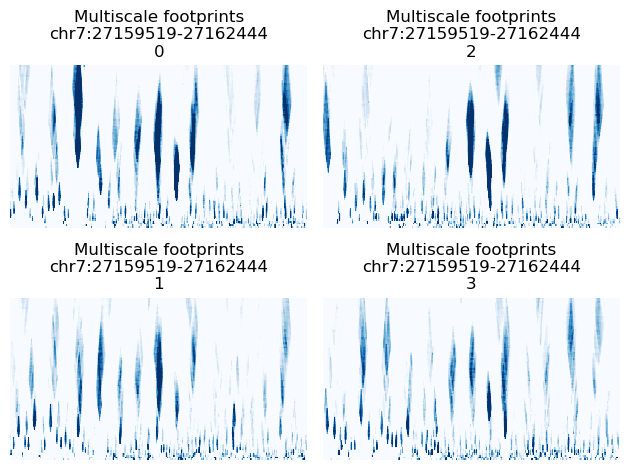

In [4]:
fig, axes = plt.subplots(2,2)
for i in range(2):
    for j in range(2):
        scp.pl.plot_footprints(printer,
                    save_key='trial_footprints',
                    group_names=unique_groups[i+j*2],
                    region='chr7:27159519-27162444',
                    scales=None,
                    ax=axes[i,j],
                    cmap='Blues',
                    vmin=0.5,
                    vmax=2.0)

## Calculate footprints at CTCF sites for each sample

In [5]:
# Down load Unibind CTCF sites
# Link: https://unibind.uio.no/static/data/20220914/macs/DAMO/ENCSR240PRQ.HCT-116_colon_carcinoma.CTCF/ENCSR240PRQ.HCT-116_colon_carcinoma.CTCF.MA0139.1.damo.bed
CTCF_bed_path = os.path.join(wd, 'ENCSR240PRQ.HCT-116_colon_carcinoma.CTCF.MA0139.1.damo.filt.bed')

# Load CTCF sites into a dataframe
CTCF_bed = pd.read_table(CTCF_bed_path, header = None)
      
# Only keep autosome and chrX, chrY
CTCF_bed = CTCF_bed[CTCF_bed[0].isin([f"chr{i}" for i in range(1, 23)] + ["chrX", "chrY"])]

In [6]:
# Load CTCF ChIP-Seq signal for treated and untreated samples
bw_chip_un = pyBigWig.open(os.path.join(wd, 'ENCFF575JJQ_ctcf_chip_untreated.bigWig'))
bw_chip_tr = pyBigWig.open(os.path.join(wd, 'ENCFF021PQK_ctcf_chip_treated.bigWig'))
chip_scores_un_matrix = []
chip_scores_tr_matrix = []
region_radius = 500
for i, row in tqdm(CTCF_bed.iterrows()):
    chr, start, end = row[:3]
    center = int((start + end) // 2)
    chip_scores_un_matrix.append(bw_chip_un.values(chr, center - region_radius, center + region_radius))
    chip_scores_tr_matrix.append(bw_chip_tr.values(chr, center - region_radius, center + region_radius))
chip_scores_un_matrix = np.array(chip_scores_un_matrix)
chip_scores_tr_matrix = np.array(chip_scores_tr_matrix)
chip_scores_un = np.mean(chip_scores_un_matrix[:, (region_radius - 10):(region_radius + 10)], axis=1)
chip_scores_tr = np.mean(chip_scores_tr_matrix[:, (region_radius - 10):(region_radius + 10)], axis=1)

48148it [00:13, 3697.17it/s]


In [7]:
# Retrieve insertion profile per chromosome
insertion_profile = copy.deepcopy(printer.fetch_insertion_profile())
for chrom in insertion_profile.keys():
    insertion_profile[chrom] = np.squeeze(np.array(np.sum(insertion_profile[chrom], axis = 0)))

# Calculate local accessibility around each variant
accessibility = []
for i, row in tqdm(CTCF_bed.iterrows()):
    chr, start, end = row[:3]
    center = int((start + end) // 2)
    accessibility.append(sum(insertion_profile[chr][(center - region_radius):(center + region_radius)]))
accessibility = np.array(accessibility)

# Filter sites by accessibility
accessibility_filter = accessibility > 200

# Keep sites with large reduction of ChIP signal after IAA treatment
degradation_filter = (chip_scores_un > np.percentile(chip_scores_un, 50)) & (chip_scores_tr < np.percentile(chip_scores_tr, 50))

# Combine the above filters
filter = accessibility_filter & degradation_filter

# Order the regions by ChIP-Seq signal in untreated
order = np.argsort(-chip_scores_un[filter])
chip_scores_un_matrix = chip_scores_un_matrix[filter, :][order, :]
chip_scores_tr_matrix = chip_scores_tr_matrix[filter, :][order, :]
chip_scores_un = chip_scores_un[filter][order]
chip_scores_tr = chip_scores_tr[filter][order]
CTCF_bed_filt = CTCF_bed.loc[filter, :].iloc[order, :]

48148it [00:08, 5978.38it/s]


In [8]:
# Save as a bed file
filt_bed_path = os.path.join(wd, "CTCF_unibind_filt.bed")
CTCF_bed_filt.to_csv(
    filt_bed_path, 
    index = False,
    sep = "\t",
    header = None)

# Calculate footrinting for the CTCF sites in each sample
region_width = 1000
start = time.time()
scp.tl.get_footprint_score(
    printer,
    grouping,
    unique_groups,
    filt_bed_path,
    region_width=region_width,
    modes=np.arange(2, 101),
    footprintRadius=None,
    flankRadius=None,
    nCores=16,
    save_key="degron_footprints",
    backed=True,
    overwrite=True)
adata = printer.footprintsadata['degron_footprints']
print ("takes", time.time()-start)

estimated file size: 1.69 GB
Creating degron_footprints in printer.footprintsadata
obs=groups, var=regions
4000 100


Submitting jobs:   0%|          | 0/113553 [00:00<?, ?it/s]

collecting multi-scale footprints:   0%|          | 0/113553 [00:00<?, ?it/s]

takes 31.237125396728516


## Visualize observed footprints in each sample

1147it [00:04, 239.97it/s]
2024-06-19 11:04:18 - INFO - maxp pruned
2024-06-19 11:04:18 - INFO - cmap pruned
2024-06-19 11:04:18 - INFO - kern dropped
2024-06-19 11:04:18 - INFO - post pruned
2024-06-19 11:04:18 - INFO - FFTM dropped
2024-06-19 11:04:18 - INFO - GPOS pruned
2024-06-19 11:04:18 - INFO - GSUB pruned
2024-06-19 11:04:18 - INFO - glyf pruned
2024-06-19 11:04:18 - INFO - Added gid0 to subset
2024-06-19 11:04:18 - INFO - Added first four glyphs to subset
2024-06-19 11:04:18 - INFO - Closing glyph list over 'GSUB': 13 glyphs before
2024-06-19 11:04:18 - INFO - Glyph names: ['.notdef', '.null', 'A', 'I', 'R', 'e', 'hyphen', 'nonmarkingreturn', 'one', 'p', 'plus', 'space', 'two']
2024-06-19 11:04:18 - INFO - Glyph IDs:   [0, 1, 2, 3, 14, 16, 20, 21, 36, 44, 53, 72, 83]
2024-06-19 11:04:18 - INFO - Closed glyph list over 'GSUB': 13 glyphs after
2024-06-19 11:04:18 - INFO - Glyph names: ['.notdef', '.null', 'A', 'I', 'R', 'e', 'hyphen', 'nonmarkingreturn', 'one', 'p', 'plus', 'sp

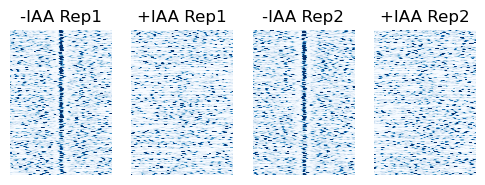

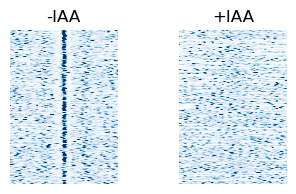

In [9]:
# Retrieve the footprint scores at a specific scale for each region in each sample
scale = 20
samples = ["-IAA Rep1", "+IAA Rep1", "-IAA Rep2", "+IAA Rep2"]
footprint_scores = {sample:[] for sample in samples}
ordered_regions = []
for i, row in tqdm(CTCF_bed_filt.iterrows()):
    chr, start, end = row[:3]
    strand = row[5]
    center = int((start + end) // 2)
    region = chr + ":" + str(center - region_radius) + "-" + str(center + region_radius)
    ordered_regions.append(region)
    for sample_ind in range(len(samples)):
        fp = adata.obsm[region][sample_ind, scale - 2, :]
        if strand == "-":
            fp = np.flip(fp)
        footprint_scores[samples[sample_ind]].append(fp) # Scale - 2 because the scales are 2-100bp.
for sample in footprint_scores.keys():
    footprint_scores[sample] = np.array(footprint_scores[sample])

# Visualize as heatmaps
edge_size = int((region_width - 800) / 2)
fig, axes = plt.subplots(1,4, figsize=(6,2))
vmax = 2
for i in range(len(samples)):
    axes[i].imshow(footprint_scores[samples[i]][:, edge_size:-edge_size], interpolation="none", cmap='Blues', vmax=vmax);
    axes[i].set_title(samples[i])
    axes[i].set_xticks([])
    axes[i].set_yticks([])
    axes[i].spines[:].set_visible(False)
plt.savefig(os.path.join(wd, "plots", "footprints_" + str(scale) + "bp_scale.pdf"))

# Collapse replicates
avg_score_dict = {}
fig, axes = plt.subplots(1,2, figsize=(4,2))
vmax = 2
for i in range(2):
    condition = ["-IAA", "+IAA"][i]
    scores_rep1 = footprint_scores[condition + " Rep1"][:, edge_size:-edge_size]
    scores_rep2 = footprint_scores[condition + " Rep2"][:, edge_size:-edge_size]
    avg_scores = (scores_rep1 + scores_rep2) / 2
    avg_score_dict[condition] = avg_scores
    axes[i].imshow(avg_scores, interpolation="none", cmap='Blues', vmax=vmax);
    axes[i].set_title(condition)
    axes[i].set_xticks([])
    axes[i].set_yticks([])
    axes[i].spines[:].set_visible(False)
plt.savefig(os.path.join(wd, "plots", "footprints_" + str(scale) + "bp_scale_rep_avg.pdf"))

## Visualize ChIP-seq signal

2024-04-01 17:50:03 - INFO - maxp pruned
2024-04-01 17:50:03 - INFO - cmap pruned
2024-04-01 17:50:03 - INFO - kern dropped
2024-04-01 17:50:03 - INFO - post pruned
2024-04-01 17:50:03 - INFO - FFTM dropped
2024-04-01 17:50:03 - INFO - GPOS pruned
2024-04-01 17:50:03 - INFO - GSUB pruned
2024-04-01 17:50:03 - INFO - glyf pruned
2024-04-01 17:50:03 - INFO - Added gid0 to subset
2024-04-01 17:50:03 - INFO - Added first four glyphs to subset
2024-04-01 17:50:03 - INFO - Closing glyph list over 'GSUB': 16 glyphs before
2024-04-01 17:50:03 - INFO - Glyph names: ['.notdef', '.null', 'A', 'C', 'I', 'P', 'five', 'h', 'hyphen', 'nonmarkingreturn', 'one', 'plus', 'seven', 'space', 'two', 'zero']
2024-04-01 17:50:03 - INFO - Glyph IDs:   [0, 1, 2, 3, 14, 16, 19, 20, 21, 24, 26, 36, 38, 44, 51, 75]
2024-04-01 17:50:03 - INFO - Closed glyph list over 'GSUB': 16 glyphs after
2024-04-01 17:50:03 - INFO - Glyph names: ['.notdef', '.null', 'A', 'C', 'I', 'P', 'five', 'h', 'hyphen', 'nonmarkingreturn', 

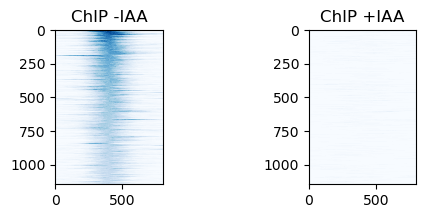

In [116]:
fig, axes = plt.subplots(1,2, figsize=(6,2))
vmax = 100
axes[0].imshow(chip_scores_un_matrix[:, edge_size:-edge_size], 
               interpolation="none", cmap='Blues', vmax=vmax);
axes[1].imshow(chip_scores_tr_matrix[:, edge_size:-edge_size], 
               interpolation="none", cmap='Blues', vmax=vmax);
axes[0].set_title('ChIP -IAA')
axes[1].set_title('ChIP +IAA')
plt.savefig(os.path.join(wd, "plots", "ChIP-seq.pdf"))

## Visualize sequence model-predicted footrpints in the presence and absence of CTCF motif

In [10]:
file_dict = {
    "-IAA Rep1":"before_Un_Rep1.npz",
    "+IAA Rep1":"after_Un_Rep1.npz",
    "-IAA Rep2":"before_Un_Rep2.npz",
    "+IAA Rep2":"after_Un_Rep2.npz"
}

# Extract predicted footprints from compressed npz files
for sample in samples:
    path = os.path.join(wd, file_dict[sample])
    with ZipFile(path, 'r') as f:
        f.extractall(path=os.path.join(wd, sample), members=['arr_0.npy'])
pred_footprints = {sample:np.load(os.path.join(wd, sample, "arr_0.npy"), mmap_mode="r") for sample in samples}

In [11]:
# For each region in the unfiltered region list, assign an ID
region_ids = []
for i, row in CTCF_bed.iterrows():
    chr, start, end = row[:3]
    center = (start + end) // 2
    resized_start, resized_end = int(center - region_width / 2), int(center + region_width / 2)
    id = row[0] + ":" + str(resized_start) + "-" + str(resized_end)
    region_ids.append(id)

# For each sampled region, find its index in the original region list
# This will be in the same order as the previous plots
region_inds = [region_ids.index(region) for region in ordered_regions]

2024-06-19 11:07:57 - INFO - maxp pruned
2024-06-19 11:07:57 - INFO - cmap pruned
2024-06-19 11:07:57 - INFO - kern dropped
2024-06-19 11:07:57 - INFO - post pruned
2024-06-19 11:07:57 - INFO - FFTM dropped
2024-06-19 11:07:57 - INFO - GPOS pruned
2024-06-19 11:07:57 - INFO - GSUB pruned
2024-06-19 11:07:57 - INFO - glyf pruned
2024-06-19 11:07:57 - INFO - Added gid0 to subset
2024-06-19 11:07:57 - INFO - Added first four glyphs to subset
2024-06-19 11:07:57 - INFO - Closing glyph list over 'GSUB': 12 glyphs before
2024-06-19 11:07:57 - INFO - Glyph names: ['.notdef', '.null', 'M', 'T', 'W', 'a', 'd', 'e', 'nonmarkingreturn', 'space', 't', 'u']
2024-06-19 11:07:57 - INFO - Glyph IDs:   [0, 1, 2, 3, 48, 55, 58, 68, 71, 72, 87, 88]
2024-06-19 11:07:57 - INFO - Closed glyph list over 'GSUB': 12 glyphs after
2024-06-19 11:07:57 - INFO - Glyph names: ['.notdef', '.null', 'M', 'T', 'W', 'a', 'd', 'e', 'nonmarkingreturn', 'space', 't', 'u']
2024-06-19 11:07:57 - INFO - Glyph IDs:   [0, 1, 2, 

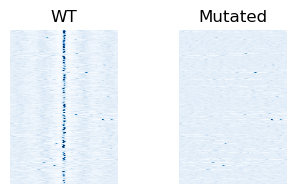

In [12]:
# Collapse replicates
scale = 20
vmax = 2
pred_radius = int(np.shape(pred_footprints["-IAA Rep1"])[2] / 2)
pred_avg_score_dict = {}
fig, axes = plt.subplots(1,2, figsize=(4,2))
for i in range(2):
    condition = ["-IAA", "+IAA"][i]
    scores_rep1 = pred_footprints[condition + " Rep1"][np.array(region_inds), scale - 2, :]
    scores_rep2 = pred_footprints[condition + " Rep2"][np.array(region_inds), scale - 2, :]
    pred_avg_scores = (scores_rep1 + scores_rep2) / 2
    pred_avg_score_dict[condition] = pred_avg_scores
    axes[i].imshow(pred_avg_scores, interpolation="none", cmap='Blues', vmax=vmax);
    if condition == "-IAA":
        axes[i].set_title("WT")
    else:
        axes[i].set_title("Mutated")
    axes[i].set_xticks([])
    axes[i].set_yticks([])
    axes[i].spines[:].set_visible(False)
plt.savefig(os.path.join(wd, "plots", "pred_footprints_" + str(scale) + "bp_scale_rep_avg.pdf"))

In [13]:
pred_diff = pred_avg_score_dict["+IAA"] - pred_avg_score_dict["-IAA"]

## Compare predicted versus observed differential footprint 

In [14]:
samples = ["-IAA Rep1", "+IAA Rep1", "-IAA Rep2", "+IAA Rep2"]

untreated_inds = np.array([0, 2])
treated_inds = np.array([1, 3])
obs_diff = []
pred_diff = []
for region in tqdm(ordered_regions):

    # Get observed differential multi-scale footprints for the current region
    treated_footprints = np.mean(adata.obsm[region][treated_inds, :, 100:-100], axis=0)
    untreated_footprints = np.mean(adata.obsm[region][untreated_inds, :, 100:-100], axis=0)
    obs_diff.append(treated_footprints - untreated_footprints)

    # Get predicted differential multi-scale footprints for the current region
    region_ind = region_ids.index(region)
    pred_mutate_footprints = (pred_footprints["+IAA Rep1"][region_ind, :, :] +
                          pred_footprints["+IAA Rep2"][region_ind, :, :]) / 2
    pred_WT_footprints = (pred_footprints["-IAA Rep1"][region_ind, :, :] +
                          pred_footprints["-IAA Rep2"][region_ind, :, :]) / 2
    pred_diff.append(pred_mutate_footprints - pred_WT_footprints)               

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1147/1147 [00:03<00:00, 318.09it/s]


2024-06-19 11:13:08 - INFO - maxp pruned
2024-06-19 11:13:08 - INFO - cmap pruned
2024-06-19 11:13:08 - INFO - kern dropped
2024-06-19 11:13:08 - INFO - post pruned
2024-06-19 11:13:08 - INFO - FFTM dropped
2024-06-19 11:13:08 - INFO - GPOS pruned
2024-06-19 11:13:08 - INFO - GSUB pruned
2024-06-19 11:13:08 - INFO - glyf pruned
2024-06-19 11:13:08 - INFO - Added gid0 to subset
2024-06-19 11:13:08 - INFO - Added first four glyphs to subset
2024-06-19 11:13:08 - INFO - Closing glyph list over 'GSUB': 32 glyphs before
2024-06-19 11:13:08 - INFO - Glyph names: ['.notdef', '.null', 'C', 'F', 'a', 'b', 'c', 'd', 'e', 'f', 'five', 'four', 'i', 'l', 'minus', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'period', 'q', 'r', 'seven', 'space', 't', 'three', 'two', 'u', 'w', 'y', 'zero']
2024-06-19 11:13:08 - INFO - Glyph IDs:   [0, 1, 2, 3, 17, 19, 20, 21, 22, 23, 24, 26, 38, 41, 68, 69, 70, 71, 72, 73, 76, 79, 81, 82, 83, 84, 85, 87, 88, 90, 92, 3228]
2024-06-19 11:13:08 - INFO - Closed glyph list o

0.6647320190285849


2024-06-19 11:13:08 - INFO - GSUB pruned
2024-06-19 11:13:08 - INFO - name pruned


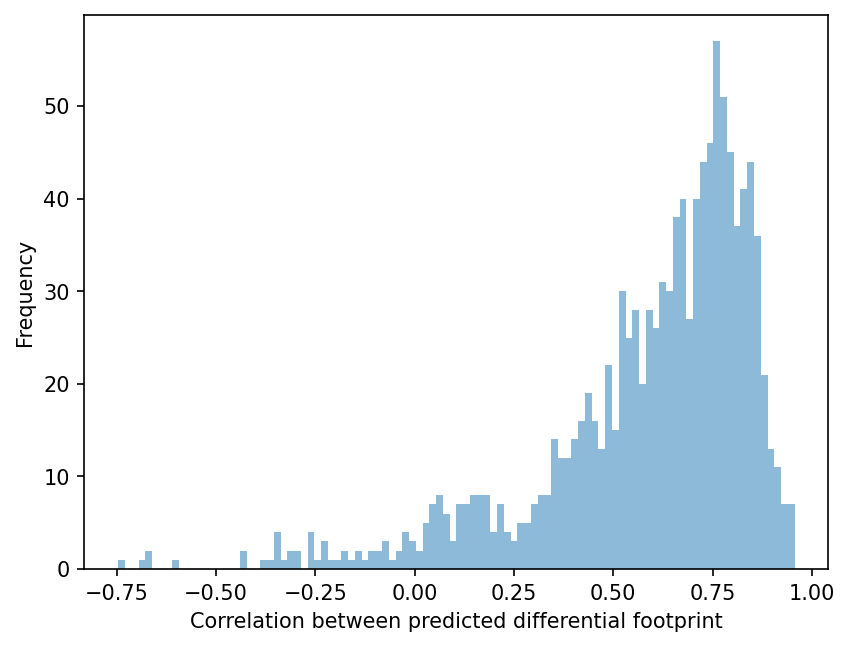

In [15]:
# For each site, calculate correlation between observed and predicted changes
selected_scales = np.array([50])
corrs = [ss.pearsonr(obs_diff[i][selected_scales, :].reshape((-1)), pred_diff[i][selected_scales, :].reshape((-1))).correlation for i in range(len(obs_diff))]
print(np.median(corrs))
plt.figure(dpi=150)
plt.hist(corrs, bins=100, alpha=0.5)
plt.xlabel("Correlation between predicted differential footprint")
plt.ylabel("Frequency")
plt.savefig(os.path.join(wd, "plots", "diff_correlation.pdf"))
plt.show()

2024-06-19 11:13:19 - INFO - maxp pruned
2024-06-19 11:13:19 - INFO - cmap pruned
2024-06-19 11:13:19 - INFO - kern dropped
2024-06-19 11:13:19 - INFO - post pruned
2024-06-19 11:13:19 - INFO - FFTM dropped
2024-06-19 11:13:19 - INFO - GPOS pruned
2024-06-19 11:13:19 - INFO - GSUB pruned
2024-06-19 11:13:19 - INFO - glyf pruned
2024-06-19 11:13:19 - INFO - Added gid0 to subset
2024-06-19 11:13:19 - INFO - Added first four glyphs to subset
2024-06-19 11:13:19 - INFO - Closing glyph list over 'GSUB': 16 glyphs before
2024-06-19 11:13:19 - INFO - Glyph names: ['.notdef', '.null', 'eight', 'five', 'four', 'minus', 'nine', 'nonmarkingreturn', 'one', 'period', 'seven', 'six', 'space', 'three', 'two', 'zero']
2024-06-19 11:13:19 - INFO - Glyph IDs:   [0, 1, 2, 3, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 3228]
2024-06-19 11:13:19 - INFO - Closed glyph list over 'GSUB': 16 glyphs after
2024-06-19 11:13:19 - INFO - Glyph names: ['.notdef', '.null', 'eight', 'five', 'four', 'minus', 'nine', 'n

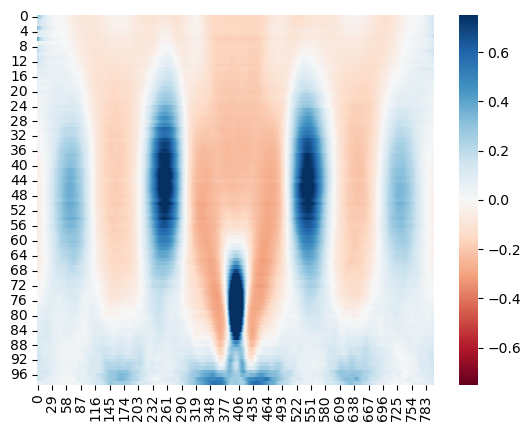

2024-06-19 11:13:25 - INFO - maxp pruned
2024-06-19 11:13:25 - INFO - cmap pruned
2024-06-19 11:13:25 - INFO - kern dropped
2024-06-19 11:13:25 - INFO - post pruned
2024-06-19 11:13:25 - INFO - FFTM dropped
2024-06-19 11:13:25 - INFO - GPOS pruned
2024-06-19 11:13:25 - INFO - GSUB pruned
2024-06-19 11:13:25 - INFO - glyf pruned
2024-06-19 11:13:25 - INFO - Added gid0 to subset
2024-06-19 11:13:25 - INFO - Added first four glyphs to subset
2024-06-19 11:13:25 - INFO - Closing glyph list over 'GSUB': 16 glyphs before
2024-06-19 11:13:25 - INFO - Glyph names: ['.notdef', '.null', 'eight', 'five', 'four', 'minus', 'nine', 'nonmarkingreturn', 'one', 'period', 'seven', 'six', 'space', 'three', 'two', 'zero']
2024-06-19 11:13:25 - INFO - Glyph IDs:   [0, 1, 2, 3, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 3228]
2024-06-19 11:13:25 - INFO - Closed glyph list over 'GSUB': 16 glyphs after
2024-06-19 11:13:25 - INFO - Glyph names: ['.notdef', '.null', 'eight', 'five', 'four', 'minus', 'nine', 'n

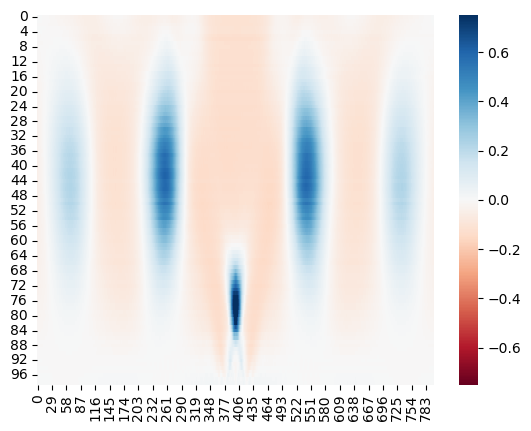

In [16]:
sns.heatmap(np.flip(-np.mean(obs_diff, axis = 0)), cmap="RdBu", vmin = -0.75, vmax = 0.75)
plt.savefig(os.path.join(wd, "plots", "aggregate_obs_diff.pdf"))
plt.show()

sns.heatmap(np.flip(-np.mean(pred_diff, axis = 0)), cmap="RdBu", vmin = -0.75, vmax = 0.75)
plt.savefig(os.path.join(wd, "plots", "aggregate_pred_diff.pdf"))
plt.show()

In [24]:
ss.pearsonr(
    -np.mean(obs_diff, axis = 0).reshape(-1),
    -np.mean(pred_diff, axis = 0).reshape(-1))

PearsonRResult(statistic=0.9290490181782419, pvalue=0.0)